In [8]:
#
import os
import numpy as np
import importlib
from constants import ENVIRONMENT_PATH
from constants import EARTH
import calculations as calculations
import plotter as plotter

#
import WK99_signal_processing as signal_processing
from Vallis_dispersion_relation import *
from utils import (
    get_f_beta,
    get_gravity_wave_speed,
    rescale_to_days_and_ordinary_frequency,
)

In [9]:
do_preliminary_analysis_1 = False
do_preliminary_analysis_2 = True

## Preliminary Analysis #1

In [10]:
if do_preliminary_analysis_1:
    zws_raw, zws_smoothed, zws_smoothed_grad = calculations.calculate_zonal_wind_shear(
        os.path.join(ENVIRONMENT_PATH.ABSOLUTE_PATH_ERA5, "u.nc")
    )

    years = np.arange(1979, 2022)
    onset_days = np.argmax(zws_smoothed > 0, axis=1)
    monsoon_onset = dict(zip(years.tolist(), onset_days.tolist()))

    monsoon_onset_sorted = dict(sorted(monsoon_onset.items(), key=lambda item: item[1]))
    _, occurrence_raw, occurrence_smoothed = calculations.calculate_occurrence(
        os.path.join(
            ENVIRONMENT_PATH.ABSOLUTE_PATH_TEMPEST, "TropicalCycloneCount_925.csv"
        )
    )

    streamfunction_raw, streamfunction_smoothed, streamfunction_grids = (
        calculations.calculate_streamfunction(
            os.path.join(ENVIRONMENT_PATH.ABSOLUTE_PATH_ERA5, "divergent_uv.nc")
        )
    )
    equiv_theta_raw, equiv_theta_smoothed, equiv_theta_grids = (
        calculations.calculate_equiv_theta(
            os.path.join(ENVIRONMENT_PATH.ABSOLUTE_PATH_ERA5, "equiv_theta.nc")
        )
    )
    mse_flux_raw, mse_flux_smoothed, mse_flux_grids = (
        calculations.calculate_MSE_vertical_flux(
            os.path.join(ENVIRONMENT_PATH.ABSOLUTE_PATH_ERA5, "MSE.nc"),
            os.path.join(ENVIRONMENT_PATH.ABSOLUTE_PATH_ERA5, "w.nc"),
        )
    )
    figure_object = plotter.display_ZWS_evolution(
        (zws_raw, zws_smoothed, zws_smoothed_grad, occurrence_smoothed)
    )
    figure_object.savefig(
        os.path.join(ENVIRONMENT_PATH.ABSOLUTE_PATH_IMAGES, "ZWS_chart.png")
    )

    # Parameters
    start = 90  # Calendar day
    step = 90  # Days

    sorted_indices = np.argsort(list(monsoon_onset.values()))
    early_onset_indices = sorted_indices[:10]
    late_onset_indices = sorted_indices[-10:]

    streamfunction_early_composite = np.mean(
        streamfunction_smoothed[early_onset_indices], axis=0
    )
    streamfunction_late_composite = np.mean(
        streamfunction_smoothed[late_onset_indices], axis=0
    )
    equiv_theta_early_composite = np.mean(
        equiv_theta_smoothed[early_onset_indices], axis=0
    )
    equiv_theta_late_composite = np.mean(
        equiv_theta_smoothed[late_onset_indices], axis=0
    )
    mse_flux_early_composite = np.mean(mse_flux_smoothed[early_onset_indices], axis=0)
    mse_flux_late_composite = np.mean(mse_flux_smoothed[late_onset_indices], axis=0)

    mse_flux_early_divergence = np.gradient(
        mse_flux_early_composite, mse_flux_grids[0] * 100, axis=1
    )
    mse_flux_late_divergence = np.gradient(
        mse_flux_late_composite, mse_flux_grids[0] * 100, axis=1
    )

    # Streamfunction
    animation_object = plotter.display_streamfunction_composites_evolution(
        latitudes=streamfunction_grids[1],
        pressure_levels=streamfunction_grids[0],
        sf=(streamfunction_early_composite, streamfunction_late_composite),
        start=start,
        step=step,
    )
    animation_object.save(
        os.path.join(
            ENVIRONMENT_PATH.ABSOLUTE_PATH_IMAGES, "streamfunction_composites.mp4"
        )
    )

    # Equivalent potential temperature
    animation_object = plotter.display_equiv_theta_composites_evolution(
        latitudes=equiv_theta_grids[1],
        pressure_levels=equiv_theta_grids[0],
        equiv_theta=(equiv_theta_early_composite, equiv_theta_late_composite),
        start=start,
        step=step,
    )
    animation_object.save(
        os.path.join(
            ENVIRONMENT_PATH.ABSOLUTE_PATH_IMAGES,
            "equivalent_potential_temperature_composites.mp4",
        )
    )

    # Streamfunction and Equivalent potential temperature
    animation_object = plotter.display_sf_equiv_theta_composite_evolution(
        latitudes_sf=streamfunction_grids[1],
        pressure_levels_sf=streamfunction_grids[0],
        sf=streamfunction_early_composite,
        latitudes_equiv_theta=equiv_theta_grids[1],
        pressure_levels_equiv_theta=equiv_theta_grids[0],
        equiv_theta=equiv_theta_early_composite,
        start=start,
        step=step,
    )
    animation_object.save(
        os.path.join(
            ENVIRONMENT_PATH.ABSOLUTE_PATH_IMAGES,
            "streamfunction_and_equiv_theta_composites.mp4",
        )
    )

    # Moist Static Energy Flux
    animation_object = plotter.display_mse_flux_composites_evolution(
        latitudes=mse_flux_grids[1],
        pressure_levels=mse_flux_grids[0],
        mse_flux=(mse_flux_early_composite, mse_flux_late_composite),
        start=start,
        step=step,
    )
    animation_object.save(
        os.path.join(ENVIRONMENT_PATH.ABSOLUTE_PATH_IMAGES, "MSE_composites.mp4")
    )

    # Moist Static Energy Flux Divergence
    animation_object = plotter.display_mse_flux_divergence_composites_evolution(
        latitudes=mse_flux_grids[1],
        pressure_levels=mse_flux_grids[0],
        mse_flux_divergence=(mse_flux_early_divergence, mse_flux_late_divergence),
        start=start,
        step=step,
    )
    animation_object.save(
        os.path.join(
            ENVIRONMENT_PATH.ABSOLUTE_PATH_IMAGES, "MSE_divergence_composites.mp4"
        )
    )

    # Streamfunction and Moist Static Energy Flux
    animation_object = plotter.display_mse_streamfunction_composite_evolution(
        latitudes_sf=streamfunction_grids[1],
        pressure_levels_sf=streamfunction_grids[0],
        sf=streamfunction_early_composite,
        latitudes_mse_flux=mse_flux_grids[1],
        pressure_levels_mse_flux=mse_flux_grids[0],
        mse_flux=mse_flux_early_composite,
        start=start,
        step=step,
    )
    animation_object.save(
        os.path.join(
            ENVIRONMENT_PATH.ABSOLUTE_PATH_IMAGES,
            "streamfunction_and_MSE_composites.mp4",
        )
    )

## Preliminary Analysis #2

In [11]:
def process_variable_in_chunks(data, chunk_size):
    # Init
    from constants import REGIONAL_MASK_TUPLE

    times = data["time"][:]
    longitudes = data["lon"][:]
    latitudes = data["lat"][:]
    # pressure_levels = data["plev"][:] / 100

    latitude_mask = (latitudes > REGIONAL_MASK_TUPLE[1]) & (
        latitudes < REGIONAL_MASK_TUPLE[0]
    )
    longitude_mask = (longitudes > REGIONAL_MASK_TUPLE[3]) & (
        longitudes < REGIONAL_MASK_TUPLE[2]
    )
    latitudes = latitudes[latitude_mask]
    longitudes = longitudes[longitude_mask]

    num_timesteps = len(times)
    symmetric_all = []
    antisymmetric_all = []

    # Process data in chunks
    for i in range(0, num_timesteps, chunk_size):
        # Determine the end of the chunk
        end = min(i + chunk_size, num_timesteps)
        # Read the chunk of vorticity data
        data_chunk = data["olr"][i:end, :, :]
        # data_chunk = data["v"][i:end, 1, :, :]
        # Symmetric and antisymmetric decomposition for the chunk
        symmetric_chunk, antisymmetric_chunk = (
            signal_processing.decompose_symmetric_antisymmetric(data_chunk, axis=1)
        )
        # Crop using the latitude mask
        symmetric_chunk = symmetric_chunk[:, latitude_mask, :]
        antisymmetric_chunk = antisymmetric_chunk[:, latitude_mask, :]
        # Store the processed chunks in lists
        symmetric_all.append(symmetric_chunk)
        antisymmetric_all.append(antisymmetric_chunk)
    # Concatenate all chunks along the time axis
    symmetric_all = np.concatenate(symmetric_all, axis=0)
    antisymmetric_all = np.concatenate(antisymmetric_all, axis=0)

    return (
        symmetric_all,
        antisymmetric_all,
        (times, latitudes, longitudes),
    )

In [12]:
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
from netCDF4 import Dataset as ncDataset

# filepath = os.path.join(ENVIRONMENT_PATH.ABSOLUTE_PATH_ERA5, "v.nc")
filepath = os.path.join(ENVIRONMENT_PATH.ABSOLUTE_PATH_SATELLITE_TEST, "OLR_raw.nc")
data = ncDataset(filepath)
symmetric, antisymmetric, grids = process_variable_in_chunks(data, chunk_size=500)
# Compute PSD for symmetric, antisymmetric, and total
psd_symmetric, spectral_grid = signal_processing.compute_stochastic_PSD(
    symmetric, grids
)
psd_antisymmetric, spectral_grid = signal_processing.compute_stochastic_PSD(
    antisymmetric, grids
)
psd_total = psd_symmetric + psd_antisymmetric

# Apply filtering to obtain background PSD
background_psd = signal_processing.apply_121_filter(
    signal_processing.apply_121_filter(psd_total / 2, axis=2, iterations=10),
    axis=0,
    iterations=10,
)

# Dimensionalize frequency
# From nondimensional ordinary wavenumber to ordinary wavenumber
# (cycles) -->  (cycles/day)
spectral_grid = (spectral_grid[0] / 96, spectral_grid[1], spectral_grid[2])

positive_symmetric_psd, positive_spectral_grid = signal_processing.extract_positive_PSD(
    psd_symmetric, spectral_grid
)
positive_antisymmetric_psd, positive_spectral_grid = (
    signal_processing.extract_positive_PSD(psd_symmetric, spectral_grid)
)
positive_background_psd, positive_spectral_grid = (
    signal_processing.extract_positive_PSD(psd_symmetric, spectral_grid)
)

Text(0.5, 0.98, 'OLR')

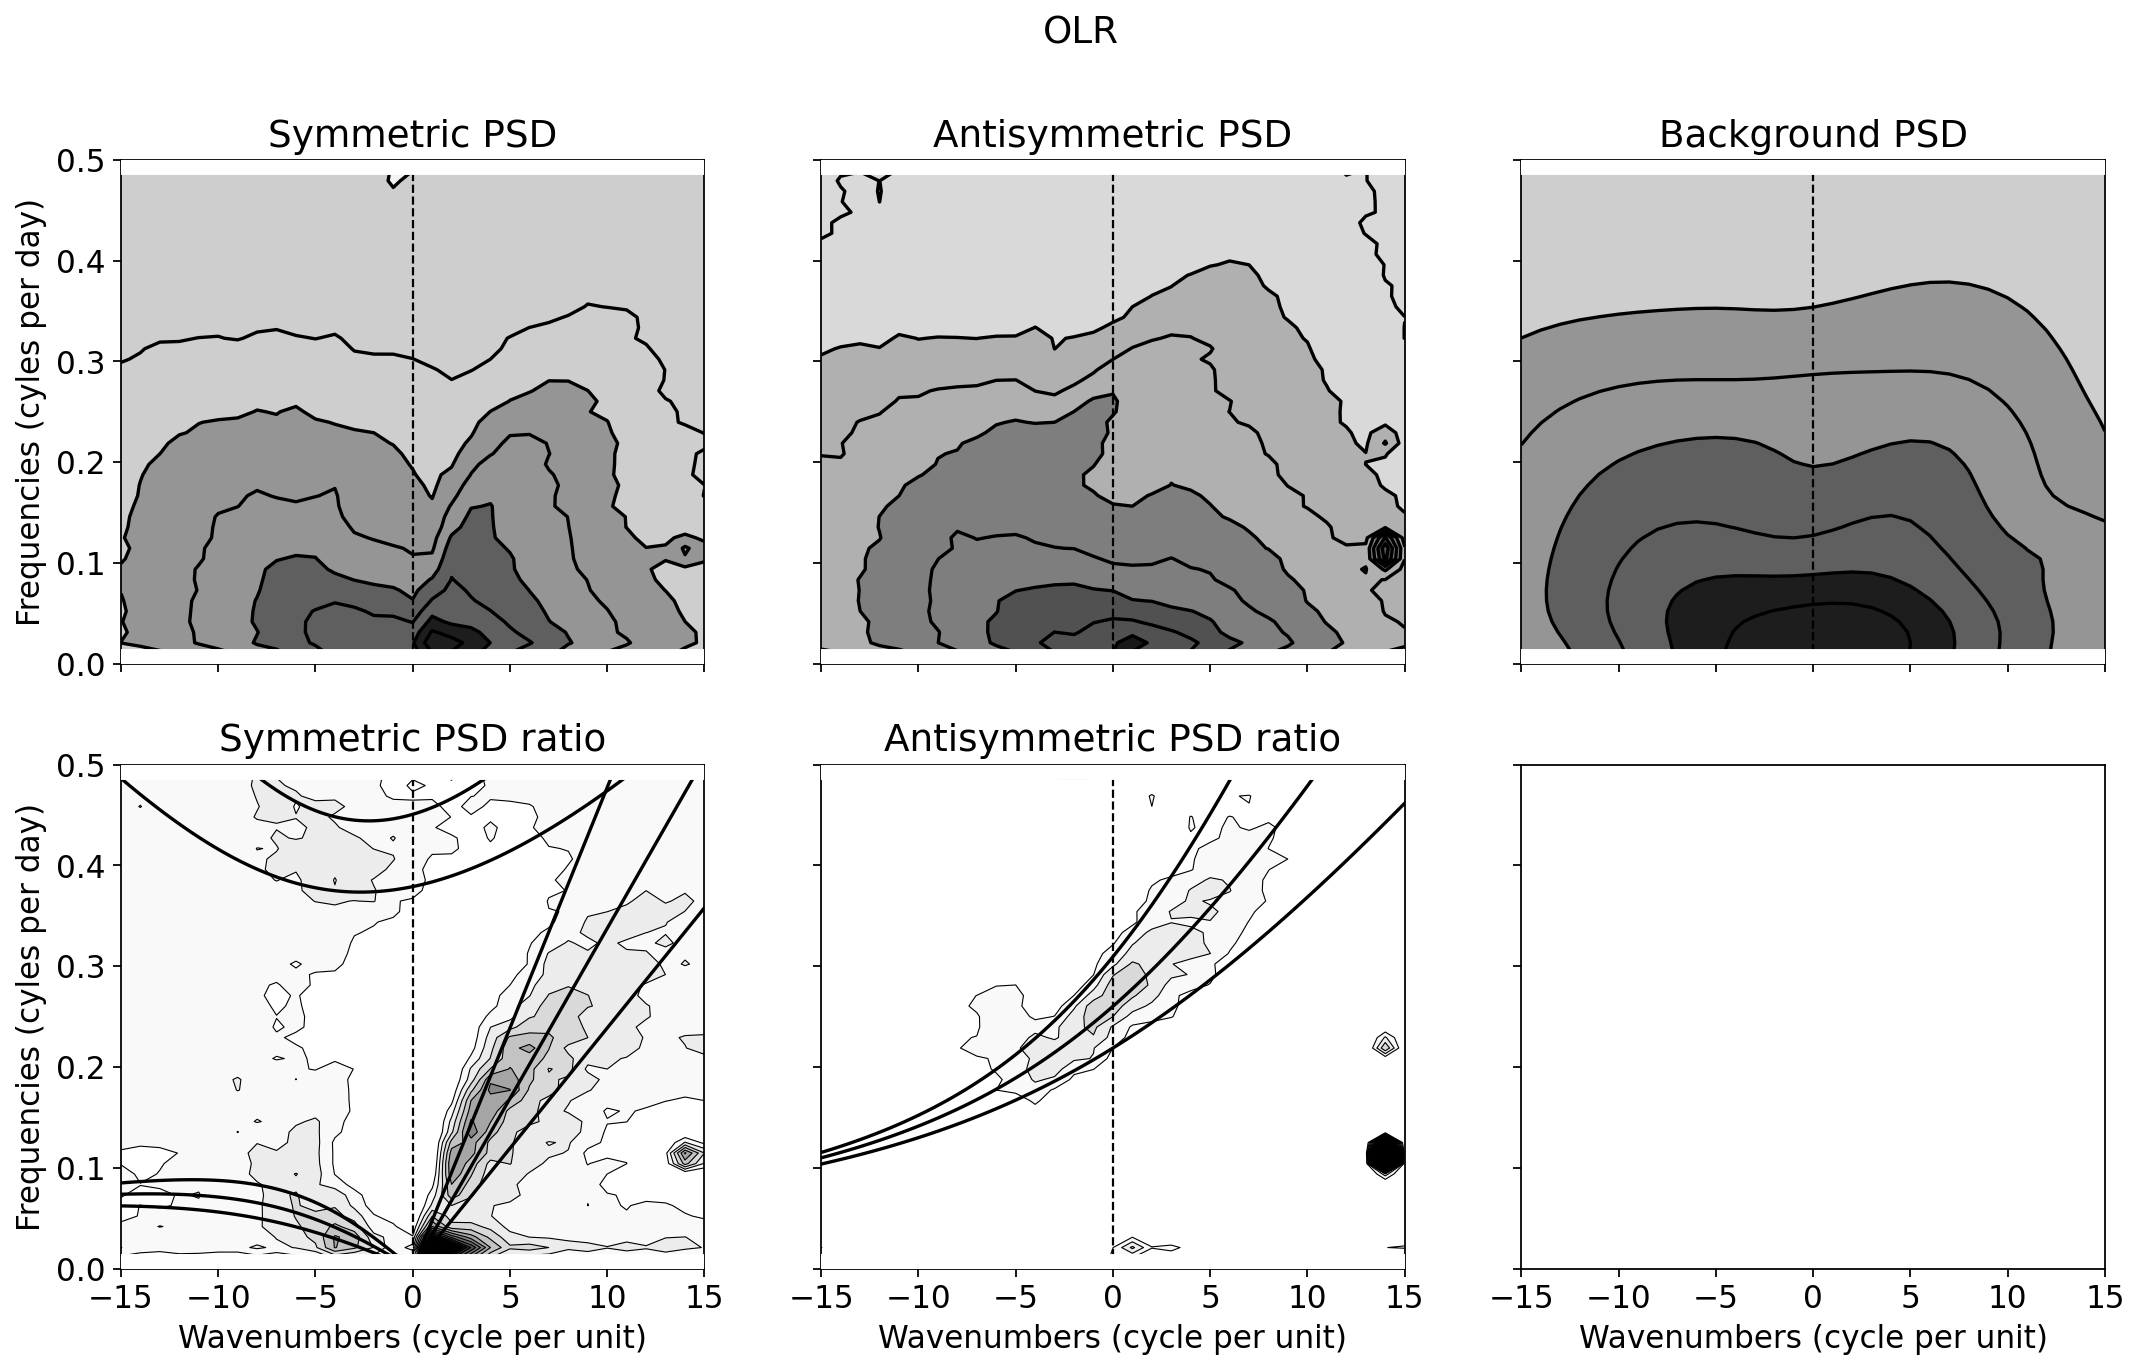

In [13]:
positive_symmetric_psd, positive_spectral_grid = signal_processing.extract_positive_PSD(
    psd_symmetric, spectral_grid
)
positive_antisymmetric_psd, positive_spectral_grid = (
    signal_processing.extract_positive_PSD(psd_antisymmetric, spectral_grid)
)
positive_background_psd, positive_spectral_grid = (
    signal_processing.extract_positive_PSD(background_psd, spectral_grid)
)

wavenum_indices = slice(
    np.argmax(spectral_grid[-1] >= -15),
    np.argmax(spectral_grid[-1] >= 15) + 1,
)

#
zonal_wavemodes = np.linspace(-15, 15, 121)
reference_latitude_rad = np.deg2rad(0.0)
equivalent_depths = np.array([50.0, 25.0, 12.5])

#
zonal_wavenumbers = zonal_wavemodes / EARTH.RADIUS
f_coriolis, rossby_parameter = get_f_beta(reference_latitude_rad)
gravity_wave_speeds = get_gravity_wave_speed(equivalent_depths)

#
characteristic_length = np.sqrt(gravity_wave_speeds / rossby_parameter)
characteristic_time = 1 / np.sqrt(gravity_wave_speeds * rossby_parameter)

frequency_kelvin = rescale_to_days_and_ordinary_frequency(
    dispersion_kelvin(zonal_wavenumbers[:, np.newaxis] * characteristic_length)
    * (1 / characteristic_time)
)
frequency_mrg = rescale_to_days_and_ordinary_frequency(
    dispersion_mrg(zonal_wavenumbers[:, np.newaxis] * characteristic_length)
    * (1 / characteristic_time)
)
frequency_poincare_m1 = rescale_to_days_and_ordinary_frequency(
    dispersion_poincare(zonal_wavenumbers[:, np.newaxis] * characteristic_length, m=1)
    * (1 / characteristic_time)
)
frequency_poincare_m2 = rescale_to_days_and_ordinary_frequency(
    dispersion_poincare(zonal_wavenumbers[:, np.newaxis] * characteristic_length, m=2)
    * (1 / characteristic_time)
)
frequency_rossby = rescale_to_days_and_ordinary_frequency(
    dispersion_rossby(zonal_wavenumbers[:, np.newaxis] * characteristic_length)
    * (1 / characteristic_time)
)

plt.rcParams.update({"font.size": 14})
fig, axes = plt.subplots(
    nrows=2, ncols=3, figsize=(16, 9), dpi=160, sharex=True, sharey=True
)

# Upper Left
axes[0, 0].contourf(
    positive_spectral_grid[-1][wavenum_indices],
    positive_spectral_grid[0],
    np.log10(np.sum(positive_symmetric_psd[:, :, wavenum_indices], axis=1)),
    cmap="Greys",
    levels=4,
)
axes[0, 0].contour(
    positive_spectral_grid[-1][wavenum_indices],
    positive_spectral_grid[0],
    np.log10(np.sum(positive_symmetric_psd[:, :, wavenum_indices], axis=1)),
    colors="black",
    levels=8,
)
axes[0, 0].add_patch(
    Rectangle(
        (zonal_wavemodes[0], positive_spectral_grid[0][0]),
        zonal_wavemodes[-1] - zonal_wavemodes[0],
        positive_spectral_grid[0][1] - positive_spectral_grid[0][0],
        edgecolor="white",
        facecolor="white",
        fill=True,
        lw=4,
        zorder=10,
    )
)
axes[0, 0].add_patch(
    Rectangle(
        (zonal_wavemodes[0], positive_spectral_grid[0][-2]),
        zonal_wavemodes[-1] - zonal_wavemodes[0],
        positive_spectral_grid[0][1] - positive_spectral_grid[0][0],
        edgecolor="white",
        facecolor="white",
        fill=True,
        lw=4,
        zorder=10,
    )
)
axes[0, 0].plot([0, 0], [0, 0.5], "k--", lw=1)
axes[0, 0].set_ylabel("Frequencies (cyles per day)")
axes[0, 0].set_title("Symmetric PSD")

# Upper Middle
axes[0, 1].contourf(
    positive_spectral_grid[-1][wavenum_indices],
    positive_spectral_grid[0],
    np.log10(np.sum(positive_antisymmetric_psd[:, :, wavenum_indices], axis=1)),
    cmap="Greys",
    levels=4,
)
axes[0, 1].contour(
    positive_spectral_grid[-1][wavenum_indices],
    positive_spectral_grid[0],
    np.log10(np.sum(positive_antisymmetric_psd[:, :, wavenum_indices], axis=1)),
    colors="black",
    levels=8,
)
axes[0, 1].add_patch(
    Rectangle(
        (zonal_wavemodes[0], positive_spectral_grid[0][0]),
        zonal_wavemodes[-1] - zonal_wavemodes[0],
        positive_spectral_grid[0][1] - positive_spectral_grid[0][0],
        edgecolor="white",
        facecolor="white",
        fill=True,
        lw=4,
        zorder=10,
    )
)
axes[0, 1].add_patch(
    Rectangle(
        (zonal_wavemodes[0], positive_spectral_grid[0][-2]),
        zonal_wavemodes[-1] - zonal_wavemodes[0],
        positive_spectral_grid[0][1] - positive_spectral_grid[0][0],
        edgecolor="white",
        facecolor="white",
        fill=True,
        lw=4,
        zorder=10,
    )
)
axes[0, 1].plot([0, 0], [0, 0.5], "k--", lw=1)
axes[0, 1].set_title("Antisymmetric PSD")

# Upper Right
axes[0, 2].contourf(
    positive_spectral_grid[-1][wavenum_indices],
    positive_spectral_grid[0],
    np.log10(np.sum(positive_background_psd[:, :, wavenum_indices], axis=1)),
    cmap="Greys",
    levels=4,
)
axes[0, 2].contour(
    positive_spectral_grid[-1][wavenum_indices],
    positive_spectral_grid[0],
    np.log10(np.sum(positive_background_psd[:, :, wavenum_indices], axis=1)),
    colors="black",
    levels=8,
)
axes[0, 2].add_patch(
    Rectangle(
        (zonal_wavemodes[0], positive_spectral_grid[0][0]),
        zonal_wavemodes[-1] - zonal_wavemodes[0],
        positive_spectral_grid[0][1] - positive_spectral_grid[0][0],
        edgecolor="white",
        facecolor="white",
        fill=True,
        lw=4,
        zorder=10,
    )
)
axes[0, 2].add_patch(
    Rectangle(
        (zonal_wavemodes[0], positive_spectral_grid[0][-2]),
        zonal_wavemodes[-1] - zonal_wavemodes[0],
        positive_spectral_grid[0][1] - positive_spectral_grid[0][0],
        edgecolor="white",
        facecolor="white",
        fill=True,
        lw=4,
        zorder=10,
    )
)
axes[0, 2].plot([0, 0], [0, 0.5], "k--", lw=1)
axes[0, 2].set_title("Background PSD")


# Lower Left
axes[1, 0].contourf(
    positive_spectral_grid[-1][wavenum_indices],
    positive_spectral_grid[0],
    np.sum(positive_symmetric_psd[:, :, wavenum_indices], axis=1)
    / np.sum(positive_background_psd[:, :, wavenum_indices], axis=1),
    cmap="Greys",
    levels=np.linspace(1.0, 3, 11),
    extend="max",
)
axes[1, 0].contour(
    positive_spectral_grid[-1][wavenum_indices],
    positive_spectral_grid[0],
    np.sum(positive_symmetric_psd[:, :, wavenum_indices], axis=1)
    / np.sum(positive_background_psd[:, :, wavenum_indices], axis=1),
    colors="black",
    levels=np.linspace(1.0, 3, 11),
    linewidths=0.5,
)
axes[1, 0].add_patch(
    Rectangle(
        (zonal_wavemodes[0], positive_spectral_grid[0][0]),
        zonal_wavemodes[-1] - zonal_wavemodes[0],
        positive_spectral_grid[0][1] - positive_spectral_grid[0][0],
        edgecolor="white",
        facecolor="white",
        fill=True,
        lw=4,
        zorder=10,
    )
)
axes[1, 0].add_patch(
    Rectangle(
        (zonal_wavemodes[0], positive_spectral_grid[0][-2]),
        zonal_wavemodes[-1] - zonal_wavemodes[0],
        positive_spectral_grid[0][1] - positive_spectral_grid[0][0],
        edgecolor="white",
        facecolor="white",
        fill=True,
        lw=4,
        zorder=10,
    )
)
axes[1, 0].plot(zonal_wavemodes, frequency_kelvin[:, :], "k-")
axes[1, 0].plot(zonal_wavemodes, frequency_poincare_m1[:, :], "k-")
axes[1, 0].plot(zonal_wavemodes, frequency_rossby[:, :], "k-")
axes[1, 0].plot([0, 0], [0, 0.5], "k--", lw=1)
axes[1, 0].set_xlabel("Wavenumbers (cycle per unit)")
axes[1, 0].set_ylabel("Frequencies (cyles per day)")
axes[1, 0].set_title("Symmetric PSD ratio")


# Lower Middle
axes[1, 1].contourf(
    positive_spectral_grid[-1][wavenum_indices],
    positive_spectral_grid[0],
    np.sum(positive_antisymmetric_psd[:, :, wavenum_indices], axis=1)
    / np.sum(positive_background_psd[:, :, wavenum_indices], axis=1),
    cmap="Greys",
    levels=np.linspace(1.0, 3, 11),
    extend="max",
)
axes[1, 1].contour(
    positive_spectral_grid[-1][wavenum_indices],
    positive_spectral_grid[0],
    np.sum(positive_antisymmetric_psd[:, :, wavenum_indices], axis=1)
    / np.sum(positive_background_psd[:, :, wavenum_indices], axis=1),
    colors="black",
    levels=np.linspace(1.0, 3, 11),
    linewidths=0.5,
)
axes[1, 1].add_patch(
    Rectangle(
        (zonal_wavemodes[0], positive_spectral_grid[0][0]),
        zonal_wavemodes[-1] - zonal_wavemodes[0],
        positive_spectral_grid[0][1] - positive_spectral_grid[0][0],
        edgecolor="white",
        facecolor="white",
        fill=True,
        lw=4,
        zorder=10,
    )
)
axes[1, 1].add_patch(
    Rectangle(
        (zonal_wavemodes[0], positive_spectral_grid[0][-2]),
        zonal_wavemodes[-1] - zonal_wavemodes[0],
        positive_spectral_grid[0][1] - positive_spectral_grid[0][0],
        edgecolor="white",
        facecolor="white",
        fill=True,
        lw=4,
        zorder=10,
    )
)
axes[1, 1].plot(zonal_wavemodes, frequency_mrg[:, :], "k-")
axes[1, 1].plot(zonal_wavemodes, frequency_poincare_m2[:, :], "k-")
axes[1, 1].plot([0, 0], [0, 0.5], "k--", lw=1)
axes[1, 1].set_xlabel("Wavenumbers (cycle per unit)")
axes[1, 1].set_title("Antisymmetric PSD ratio")

axes[1, 2].set_xlabel("Wavenumbers (cycle per unit)")
axes[1, 2].set_ylim(0, 0.5)

fig.suptitle("OLR")

In [14]:
if do_preliminary_analysis_2:
    pass